In [ ]:
! pip install kaggle

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
# === GPU bellek ayarları ===
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass  # Zaten ayarlanmışsa hata vermesin

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to dataset files:", path)

100%|██████████| 6.70G/6.70G [05:33<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2


In [ ]:
import os
import kagglehub

# Download latest version
downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to downloaded dataset files:", downloaded_path)

# Veri seti yolu: kagglehub tarafından indirilen path'i kullan
# İndirilen path'in içindeki 'Dataset - train+val+test' klasörüne işaret etmesi gerekiyor.
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Sınıf sayımlarını hesaplayan fonksiyon
def count_images_in_folder(folder_path):
    """Verilen klasördeki sınıfların görsel sayılarını hesaplar."""
    class_counts = {}
    # Check if the folder_path exists before listing
    if not os.path.exists(folder_path):
        print(f"Hata: Klasör bulunamadı: {folder_path}")
        return class_counts # Return empty if folder doesn't exist

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([name for name in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, name))])
            class_counts[class_name] = num_images
    return class_counts

# Klasörleri tara ve sınıf sayılarını yazdır
for folder in ['train', 'val', 'test']:
    folder_path = os.path.join(dataset_path, folder)
    print(f"\n'{folder}' klasöründeki içerikler:")

    class_counts = count_images_in_folder(folder_path)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} görsel")

Path to downloaded dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2

'train' klasöründeki içerikler:
  DME: 8118 görsel
  DRUSEN: 6206 görsel
  CNV: 26218 görsel
  NORMAL: 35973 görsel

'val' klasöründeki içerikler:
  DME: 2319 görsel
  DRUSEN: 1773 görsel
  CNV: 7491 görsel
  NORMAL: 10278 görsel

'test' klasöründeki içerikler:
  DME: 1161 görsel
  DRUSEN: 887 görsel
  CNV: 3746 görsel
  NORMAL: 5139 görsel


In [ ]:
# === Veri yolu ===
# dataset_path = "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test" # Remove this hardcoded path

# Use the path obtained from kagglehub.dataset_download
# downloaded_path is defined in the previous cell
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")


# === Dataset yükle ===
def load_datasets():
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    return train_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           val_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           test_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Call the load_datasets function and assign the returned values
train_dataset, val_dataset, test_dataset = load_datasets()

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


In [ ]:
# Veri yolları
# train_dir = "verisetin/train" # Remove this hardcoded path
# val_dir = "verisetin/val" # Remove this hardcoded path
# test_dir = "verisetin/test" # Remove this hardcoded path

# Use the dataset_path derived from kagglehub.dataset_download
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Parametreler
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(os.listdir(train_dir))  # Sınıf sayısı

# Veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode="nearest"
)

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 76515 images belonging to 4 classes.
Found 21861 images belonging to 4 classes.
Found 10933 images belonging to 4 classes.


In [ ]:
# VGG16 Modeli (ağırlıklar: ImageNet, include_top=False = FC katmanları hariç)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Önceden eğitilmiş katmanları dondur
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Özelleştirilmiş sınıflandırıcı katmanlar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Model derleme
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Model özeti
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1032s 428ms/step - accuracy: 0.6592 - loss: 0.9251 - val_accuracy: 0.7878 - val_loss: 0.5913
Epoch 2/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1009s 422ms/step - accuracy: 0.7979 - loss: 0.5779 - val_accuracy: 0.8145 - val_loss: 0.5114
Epoch 3/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1018s 426ms/step - accuracy: 0.8223 - loss: 0.5045 - val_accuracy: 0.8316 - val_loss: 0.4697
Epoch 4/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1004s 420ms/step - accuracy: 0.8348 - loss: 0.4720 - val_accuracy: 0.8429 - val_loss: 0.4429
Epoch 5/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1010s 422ms/step - accuracy: 0.8453 - loss: 0.4413 - val_accuracy: 0.8407 - val_loss: 0.4434
Epoch 6/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1016s 425ms/step - accuracy: 0.8482 - loss: 0.4312 - val_accuracy: 0.8491 - val_loss: 0.4182
Epoch 7/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1021s 427ms/step - accuracy: 0.8543 - loss: 0.4165 - val_accuracy: 0.8445 - val_loss: 0.4353
Epoch 8/10
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1020s 426ms/s

In [ ]:
# Eğitilen modeli kaydet
model.save("vgg16_model.keras")
print("Model başarıyla kaydedildi.")


Model başarıyla kaydedildi.


In [ ]:
from tensorflow.keras.models import load_model

# Kaydedilmiş modeli yükle
model = load_model("vgg16_model.h5")
print("Model başarıyla yüklendi.")

# Test verisi üzerinde tekrar değerlendir
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Yüklenen modelin test doğruluğu: {test_acc:.4f}")


Model başarıyla yüklendi.
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.6346 - loss: 9.2593
Yüklenen modelin test doğruluğu: 0.6349


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Test verisinden gerçek etiketleri ve tahminleri al
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

test_dataset = image_dataset_from_directory(
    test_path,
    labels='inferred',  # klasör isimlerinden label çıkarılacak
    image_size=(224, 224),
    batch_size=32
)

class_names = test_dataset.class_names


NotFoundError: Could not find directory /content/dataset/test

In [ ]:
test_path = "/content/dataset/test"  # ← Eğer test klasörün varsa
class_names = sorted(entry.name for entry in os.scandir(test_path) if entry.is_dir())
print(class_names)


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/test'

In [ ]:
from tensorflow.keras.models import load_model

# Modeli tekrar yükle
loaded_model = load_model('vgg16_model.h5')

# Yüklenen modeli kullanabilirsiniz


In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


TypeError: object of type 'numpy.int64' has no len()

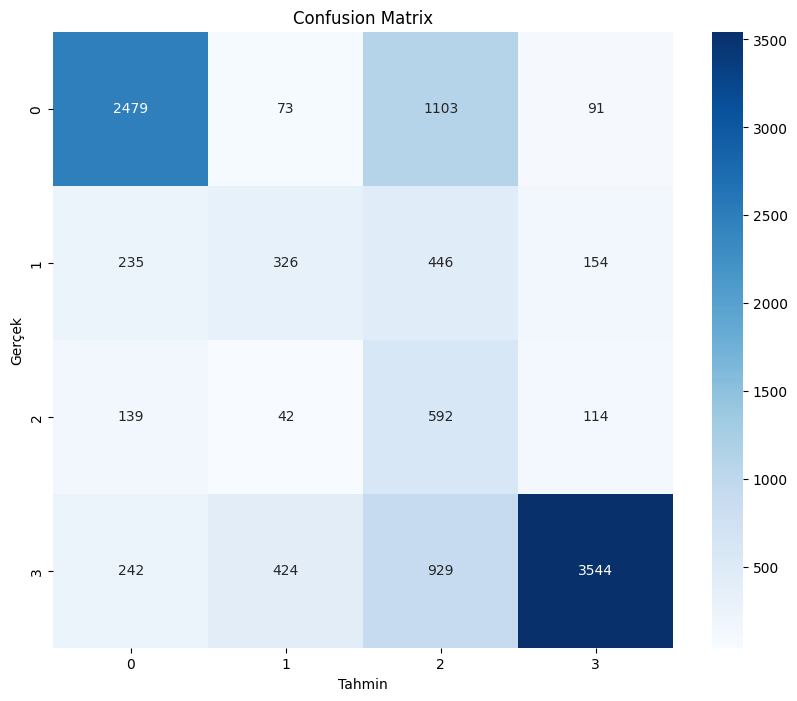

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import numpy as np
class_names = np.unique(y_true)  # Eğer y_true etiketleri sayısal ise


In [ ]:
import os

test_path = '/content/dataset/test'
print(os.path.isdir(test_path))  # True dönerse dizin var, False dönerse yok


False


In [ ]:
# Google Colab'da dizini yükleyip kontrol edin
from google.colab import drive
drive.mount('/content/drive')  # Eğer Google Drive kullanıyorsanız

# Test dizinini kontrol et
test_path = '/content/drive/My Drive/dataset/test'
print(os.path.isdir(test_path))


Mounted at /content/drive
False
